In [89]:
import cubesat.database.dbfunctions as db
from cubesat.database.dbfunctions import PowerInfo

import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
import json
import os
import datetime
import time

from IPython.display import display
from PIL import Image

In [91]:
def display_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.imshow(pixels)
    plt.axis('off')  # Hide axes
    plt.show()

In [93]:
def display_gray_image(image):
    display(Image.fromarray(image))

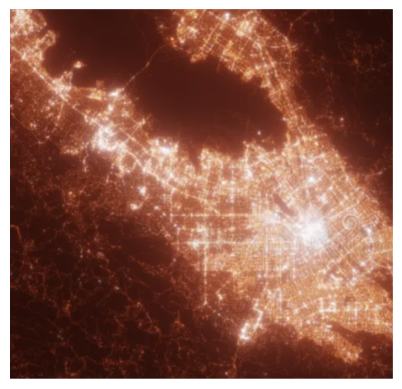

In [97]:
image = cv2.imread('./sample_image_data/45SanJose_1.png')
display_image(image)

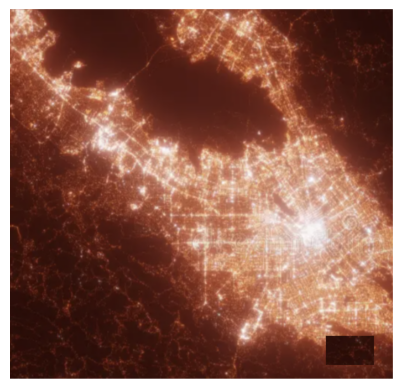

In [99]:
image = cv2.imread('./sample_image_data/45SanJose_1_outage.png')
display_image(image)

In [101]:
def convert_to_gray_img(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [103]:
gray_image = convert_to_gray_img(image)

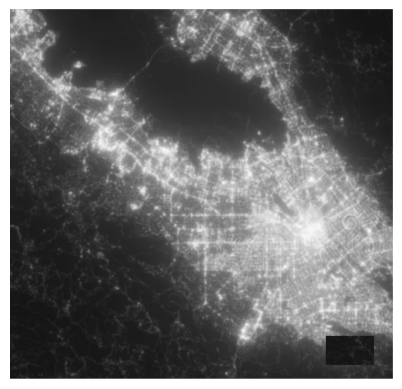

In [105]:
display_image(gray_image)

In [17]:
lat = 37.44528
lon = -122.12729
vision_scope_width = 69  #width = 69km 
vision_scope_height = 70 #height = 70km 
lat_lon_delta = 0.01 # lat ~ lon = 1km distance
brightness_threshold = 100

In [19]:
grid_size = 3 # 3km * 3km

In [21]:
class ImageBlock:
    def __init__(self, image, lat, lon):
        self.image = image
        self.lat = lat
        self.lon = lon

    def generate_key(self):
        return '{0:0.5f}'.format(self.lat) + ',' + '{0:0.5f}'.format(self.lon)

In [107]:
def split_image_to_blocks(image, lat, lon, vision_width, vision_height, grid_size = 3):
    num_of_block_x = int(vision_width / grid_size)
    num_of_block_y = int(vision_height / grid_size)
    image_width = image.shape[0]
    image_height = image.shape[1]

    top_left_lat = lat + lat_lon_delta * vision_height / 2
    top_left_lon = lon - lat_lon_delta * vision_width / 2
    right_bottom_lat = lat - lat_lon_delta * vision_height / 2
    right_bottom_lon = lon + lat_lon_delta * vision_width / 2

    block_w = int(image.shape[0] / num_of_block_x)
    block_h = int(image.shape[1] / num_of_block_y)

    block_list = []
    for i in range(0, num_of_block_x):
        for j in range(0, num_of_block_y):
            block_img = image[i*block_w:(i+1)*block_w, j*block_h:(j+1)*block_h]
            block = ImageBlock(block_img, top_left_lat - i * lat_lon_delta, top_left_lon + j * lat_lon_delta)
            block_list.append(block)
    return block_list

In [109]:
img_blocks = split_image_to_blocks(gray_image, lat, lon, vision_scope_width, vision_scope_height)

In [111]:
len(img_blocks)

529

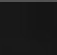

In [113]:
display_gray_image(img_blocks[20].image)

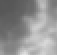

In [115]:
display_gray_image(img_blocks[200].image)

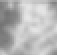

In [117]:
display_gray_image(img_blocks[0].image)

In [35]:
class OutageInfo():
    def __init__(self, block: ImageBlock, bright_avg, bright_pcnt, bright_std, probs):
        self.block = block
        self.bright_avg = bright_avg
        self.bright_pcnt = bright_pcnt
        self.bright_std = bright_std
        self.probs = probs

In [119]:
def extract_block_features(block: ImageBlock):
    bright_avg = block.image.mean()
    num_of_bright_points = np.count_nonzero(block.image > brightness_threshold)
    total_points = block.image.shape[0] * block.image.shape[1]
    bright_pcnt = num_of_bright_points / total_points
    bright_std = np.std(block.image)
    return OutageInfo(block, bright_avg, bright_pcnt, bright_std, 0.0)

In [39]:
def detect_block_outage(block_info: OutageInfo):
    block_id = block_info.block.generate_key();
    # block_historical_infos = []
    # load historical info from db
    block_historical_infos: list[PowerInfo] = db.get_list(block_id)
    if len(block_historical_infos) == 0: # no historical info
        pass # do nothing
    else:
        bright_pcnt_avg = np.mean([hb.bright_pcnt for hb in block_historical_infos])
        if bright_pcnt_avg > 0:
            block_info.probs = (bright_pcnt_avg - block_info.bright_pcnt) / bright_pcnt_avg
            block_info.probs = 0 if block_info.probs < 0 else block_info.probs

In [41]:
def build_power_info(block_info: OutageInfo):
    return PowerInfo(block_info.block.generate_key(), 
                     block_info.bright_avg, 
                     block_info.bright_pcnt, 
                     block_info.bright_std,
                     int(time.time())
                    )

In [121]:
def detect_power_outage(img_blocks):
    block_feature_list = []
    for block in img_blocks:
        block_feature_list.append(extract_block_features(block))

    for block_info in block_feature_list:
        detect_block_outage(block_info)
        
    # filter out those blocks which may have outage
    outage_alert_blocks = [block for block in block_feature_list if block.probs > 0.75]

    # filter out those blocks which has lower propability for outage
    backup_block_info = [block for block in block_feature_list if block.probs < 0.25]
    if len(backup_block_info) > 0: # back to history
        power_infos = [build_power_info(block) for block in backup_block_info]
        db.write_list(power_infos)
    
    return outage_alert_blocks

In [123]:
# outage_infos = detect_power_outage(img_blocks)

In [145]:
def detect_power_outage_image(image_path, lat, lon, vision_scope_width, vision_scope_height):
    db.init()
    image = cv2.imread(image_path)
    gray_image = convert_to_gray_img(image)
    img_blocks = split_image_to_blocks(gray_image, lat, lon, vision_scope_width, vision_scope_height)
    outage_alert_blocks = detect_power_outage(img_blocks)
    return outage_alert_blocks

In [169]:
outage_alert_blocks = detect_power_outage_image(
    './sample_image_data/45SanJose_1.png',
    lat = lat,
    lon = lon,
    vision_scope_width = vision_scope_width,
    vision_scope_height = vision_scope_height
)

In [171]:
outage_alert_blocks

[]

In [173]:
outage_alert_blocks = detect_power_outage_image(
    './sample_image_data/45SanJose_1_outage.png',
    lat = lat,
    lon = lon,
    vision_scope_width = vision_scope_width,
    vision_scope_height = vision_scope_height)

In [174]:
len(outage_alert_blocks)

4

In [177]:
def show_outage_info(outage_info: OutageInfo):
    print(f'location: {outage_info.block.generate_key()}')
    print(f'probability: {outage_info.probs}')
    display_gray_image(outage_info.block.image)

location: 37.58528,-122.28229
probability: 1.0


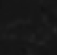

In [179]:
show_outage_info(outage_alert_blocks[0])

location: 37.58528,-122.27229
probability: 1.0


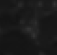

In [181]:
show_outage_info(outage_alert_blocks[1])

location: 37.58528,-122.26229
probability: 0.8859649122807018


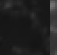

In [183]:
show_outage_info(outage_alert_blocks[2])

location: 37.57528,-122.27229
probability: 1.0


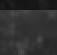

In [185]:
show_outage_info(outage_alert_blocks[3])

In [187]:
outage_alert_blocks = detect_power_outage_image(
    './sample_image_data/Blackout-images/45SanJose_2.png',
    lat = lat,
    lon = lon,
    vision_scope_width = vision_scope_width,
    vision_scope_height = vision_scope_height)

In [189]:
len(outage_alert_blocks)

19

location: 37.79528,-122.25229
probability: 1.0


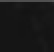

In [197]:
show_outage_info(outage_alert_blocks[3])

location: 37.76528,-122.43229
probability: 0.9020655270655271


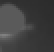

In [199]:
show_outage_info(outage_alert_blocks[5])

In [201]:
outage_alert_blocks = detect_power_outage_image(
    './sample_image_data/Blackout-images/45SanJose_3.png',
    lat = lat,
    lon = lon,
    vision_scope_width = vision_scope_width,
    vision_scope_height = vision_scope_height)

location: 37.79528,-122.25229
probability: 1.0


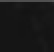

In [203]:
show_outage_info(outage_alert_blocks[5])

In [ ]:
outage_alert_blocks = detect_power_outage_image(
    './stimulation_enviroment_images/normal1.jpg',
    lat = lat,
    lon = lon,
    vision_scope_width = vision_scope_width,
    vision_scope_height = vision_scope_height
)

In [ ]:
db.print_all()

In [211]:
db.clean_up()

In [213]:
outage_alert_blocks = detect_power_outage_image(
    './stimulation_enviroment_images/normal1.jpg',
    lat = 38.995123,
    lon = -116.827956,
    vision_scope_width = 20,
    vision_scope_height = 20
)

In [215]:
len(outage_alert_blocks)

0

In [231]:
outage_alert_blocks = detect_power_outage_image(
    './stimulation_enviroment_images/normal1_blackouts/normal1_blackout1.jpg',
    lat = 38.995123,
    lon = -116.827956,
    vision_scope_width = 20,
    vision_scope_height = 20
)

In [233]:
len(outage_alert_blocks)

1

location: 39.07512,-116.91796
probability: 1.0


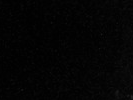

In [235]:
show_outage_info(outage_alert_blocks[0])

In [237]:
outage_alert_blocks = detect_power_outage_image(
    './stimulation_enviroment_images/normal1_blackouts/normal1_blackout2.jpg',
    lat = 38.995123,
    lon = -116.827956,
    vision_scope_width = 20,
    vision_scope_height = 20
)

In [229]:
len(outage_alert_blocks)

4

location: 39.05512,-116.88796
probability: 0.8968951376684242


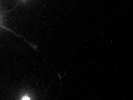

In [239]:
show_outage_info(outage_alert_blocks[0])

In [241]:
outage_alert_blocks = detect_power_outage_image(
    './stimulation_enviroment_images/normal1_blackouts/normal1_blackout3.jpg',
    lat = 38.995123,
    lon = -116.827956,
    vision_scope_width = 20,
    vision_scope_height = 20
)

In [243]:
len(outage_alert_blocks)

2

location: 39.09512,-116.89796
probability: 1.0


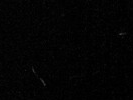

In [245]:
show_outage_info(outage_alert_blocks[0])

location: 39.08512,-116.89796
probability: 0.8434782608695652


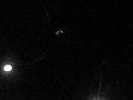

In [247]:
show_outage_info(outage_alert_blocks[1])